# Imports

In [ ]:
# Data processing
import pandas as pd
import numpy as np
from math import sqrt

# Visualization
from matplotlib import pyplot
from matplotlib.pyplot import figure

# Time Series specific packages
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA


# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load preprocessed Data
df = pd.read_pickle('Df_Prediction.pk')


In [ ]:
#Remove all unnecessary columns and set the corresponding datetime as index
df = df.drop(columns=['date_time', 'start_max_temp',
       'start_min_temp', 'start_precip', 'hour_sin', 'hour_cos', 'is_holiday',
       'is_Rush_hour', 'is_Day', 'temp_past24h', 'temp_past7days',
       'temp_past30days', 'is_rainy24h', 'open_trips', 'Is_Weekday',
       'Is_Summer', 'Is_Snowy'])
df = df.set_index('start_time')

# Is the Time Series stationary?

## Visually Identifying Seasonality and Trend

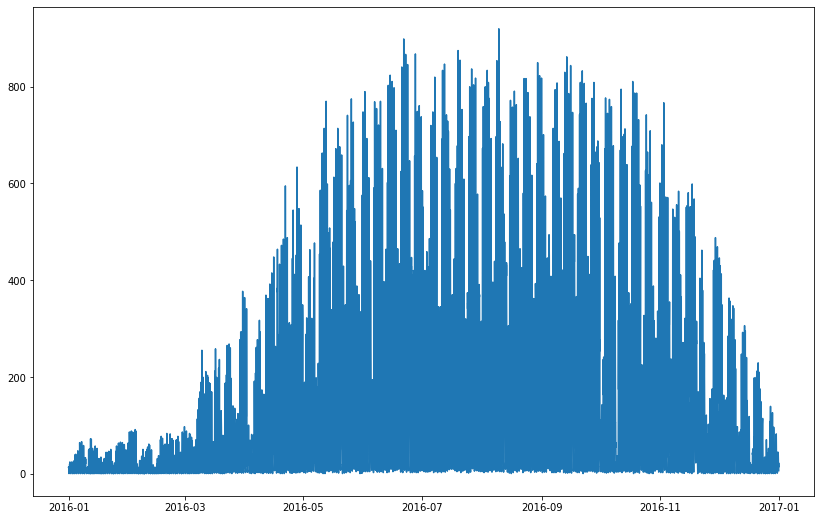

In [ ]:
# plot target variable over time
figure(figsize=(14, 9))

pyplot.plot(df['rentals_per_hour'])
pyplot.show()

Plotting the whole time series, it is fairly obvious that it contains no trend. Although, there might be some degree of seasonality involved.

## Rolling Average and Rolling Variance [1]

In [ ]:
#calculate rolling mean and rolling std over 7 Days
rmean = df.rolling('7D')['rentals_per_hour'].mean()
rstd = df.rolling('7D')['rentals_per_hour'].std()

print(rmean, rstd)

start_time
2016-01-01 00:00:00    13.000000
2016-01-01 01:00:00    13.500000
2016-01-01 02:00:00    12.000000
2016-01-01 03:00:00     9.250000
2016-01-01 04:00:00     7.400000
                         ...    
2016-12-31 19:00:00    30.565476
2016-12-31 20:00:00    30.583333
2016-12-31 21:00:00    30.648810
2016-12-31 22:00:00    30.613095
2016-12-31 23:00:00    30.577381
Name: rentals_per_hour, Length: 8784, dtype: float64 start_time
2016-01-01 00:00:00          NaN
2016-01-01 01:00:00     0.707107
2016-01-01 02:00:00     2.645751
2016-01-01 03:00:00     5.909033
2016-01-01 04:00:00     6.580274
                         ...    
2016-12-31 19:00:00    32.172559
2016-12-31 20:00:00    32.161906
2016-12-31 21:00:00    32.132983
2016-12-31 22:00:00    32.157160
2016-12-31 23:00:00    32.181279
Name: rentals_per_hour, Length: 8784, dtype: float64


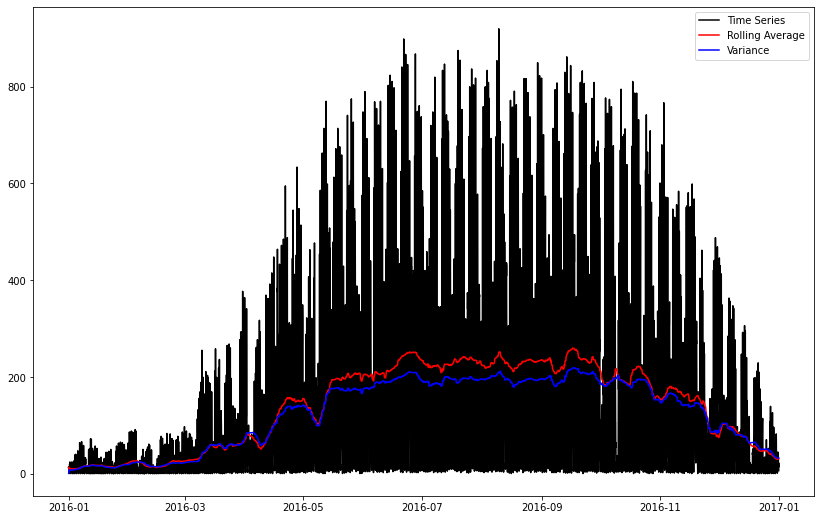

In [ ]:
# Plot Comparison of Timeseries, Rolliing Average, Variance 
figure(figsize=(14, 9))

orig = pyplot.plot(df['rentals_per_hour'], color='black', label='Time Series')
mean = pyplot.plot(rmean, color='red', label='Rolling Average')
std = pyplot.plot(rstd, color='blue', label='Variance')

pyplot.legend(loc='best')
pyplot.show()

Considering the rolling average, it can be confirmed that no clear trend can be identified.

## Dickey-Fuller Test [1]

In [ ]:
X = df['rentals_per_hour']
result = adfuller(X)

output = pd.Series(result[0:4], index=['Test Statistic', 'p-Value', 'Lags', 'Obervations'])

for key, value in result[4].items():
  output['Critical Value (%s)'%key] = value

print(output)

Test Statistic            -5.221573
p-Value                    0.000008
Lags                      37.000000
Obervations             8746.000000
Critical Value (1%)       -3.431098
Critical Value (5%)       -2.861871
Critical Value (10%)      -2.566946
dtype: float64


The Test Statistic is smaller than the Critical Values. The null-hypothesis can be rejected and the time series is declared stationary. Nonetheless, previous analyis has clearly identified seasonality within the data. Not only is there seasonality within 24 hours, where rides peak during rush hours, but also during the cycle of weekdays and weekends.

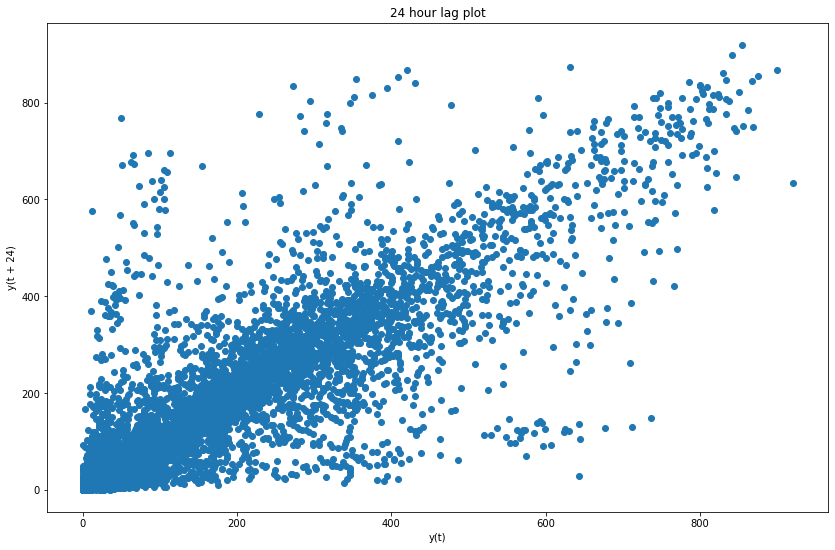

In [ ]:
figure(figsize=(14, 9))

lag_plot(df['rentals_per_hour'], lag=24)
pyplot.title('24 hour lag plot')
pyplot.show()

A 24 hour lag plot offers further evidence for the presumed seasonality. Therefore, to successfully forecast, statistical methods to remove seasonality will be employed.

## Removing Seasonality

In [ ]:
#Transform Time Series to Square Root, since log does not allow 0-values

ts_sqrt = np.sqrt(df['rentals_per_hour'])

Transformed like in the tutorial, even though there is no clear trend. Seemed to offer better results.

In [ ]:
decomposition = seasonal_decompose(ts_sqrt)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ts_sqrt_decompose = residual
ts_sqrt_decompose.dropna(inplace=True)

# Forecasting

## Auto-Correlation

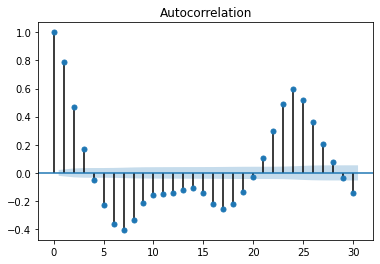

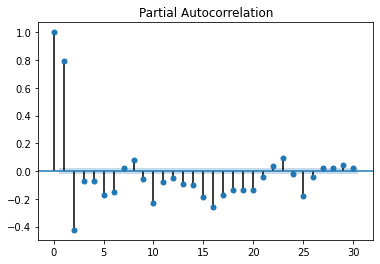

In [ ]:
plot_acf(ts_sqrt_decompose, lags=30)
pyplot.show()
plot_pacf(ts_sqrt_decompose, lags=30)
pyplot.show()

Looking at the graphs above, the following predictors can be approximately identified:

*   p = 1
*   q = 1

The decomposition is used to identify p and q, and then the normal sqrt version is used for prediction.

# Time Series Forecasting

## Splitting Time Series Data [2]

The TimeSeriesSplit module is being used to properly handle time series data. Test data has been set for one week.

In [ ]:

splitter = TimeSeriesSplit(test_size=168)
all_splits = list(splitter.split(ts_sqrt))
train_split, test_split = all_splits[0]

test = ts_sqrt.iloc[test_split].values
train = ts_sqrt.iloc[train_split].values

## ARIMA Model [3]

ARIMA Model with Rolling forecast

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

Test RMSE: 79.487
Test R2: 0.409


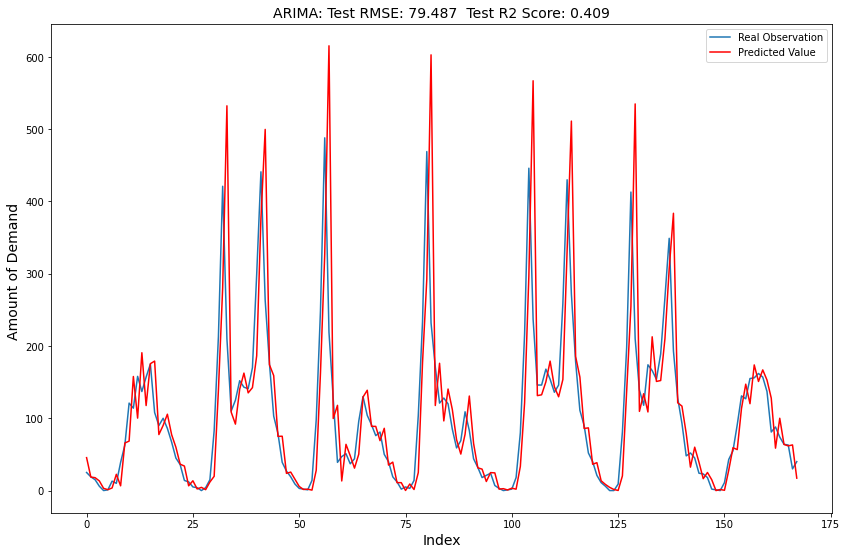

In [ ]:
#Calculate RMSE & R2
rescaled_predictions = [x **2 for x in predictions]

rmse = sqrt(mean_squared_error(df.iloc[test_split].values, rescaled_predictions))
print(f'Test RMSE: %.3f' % rmse)
r2 = r2_score(df.iloc[test_split].values, rescaled_predictions)
print('Test R2: %.3f' % r2)

figure(figsize=(14, 9))

pyplot.plot(df.iloc[test_split].values, label='Real Observation')
pyplot.plot(rescaled_predictions, color='red', label='Predicted Value')
pyplot.title(f'ARIMA: Test RMSE: {round(rmse, 3)}  Test R2 Score: {round(r2,3)}', fontsize = 14)
pyplot.ylabel('Amount of Demand ', fontsize = 14)
pyplot.xlabel('Index', fontsize = 14)

pyplot.legend(loc='best')
pyplot.show()

Considering error metrics and the visual prediction results, I assume the model to be satisfactory.

## Forecasting the Next Hour Outside of the Sample



In [ ]:
print(model_fit.forecast()[0]**2) #Forecast for the next hour and reversing the square root

[17.17671399]


The time series approach predicts 17 bike rentals for the first hour of the year 2017.

## FBprophet approach[4][5]

To further improve the results, I tried a FBProphet model. FBProphet models usually cope better with seasonality with the help of external regressors.

In [ ]:
# imports for Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
# load Data
df_2 = pd.read_pickle('Df_Prediction.pk')
df_2 = df_2.set_index('start_time')

# prepare Data for Prophet
prophet_df = df_2.rename(columns = {'rentals_per_hour':'y'})
prophet_df['ds'] = prophet_df.index

In [ ]:
#initalize model
model =Prophet(changepoint_prior_scale=0.01,seasonality_prior_scale= 24.0, changepoint_range=0.01,
               seasonality_mode = 'additive',      
								interval_width = 0.95, yearly_seasonality='auto',
								 weekly_seasonality='auto', daily_seasonality='auto')

#add external regressors
model.add_regressor('start_max_temp' , standardize = True, mode='additive'),
model.add_regressor('hour_cos', standardize = True, mode='additive'),
model.add_regressor('hour_sin', standardize = True, mode='additive'),
model.add_regressor('is_holiday', mode='additive'),
model.add_regressor('temp_past7days', standardize = True, mode='additive'),
model.add_regressor('start_precip', mode='additive'),
model.add_regressor('temp_past30days', standardize = True, mode='additive'),
model.add_regressor('is_Rush_hour', mode='additive'),
model.add_regressor('is_rainy24h', mode='additive'),
model.add_regressor('open_trips', standardize = True, mode='additive'),
model.add_regressor('Is_Summer', mode='additive'),
model.add_regressor('is_Day', mode='additive'),
model.add_regressor('Is_Weekday', mode='additive');

model.fit(prophet_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


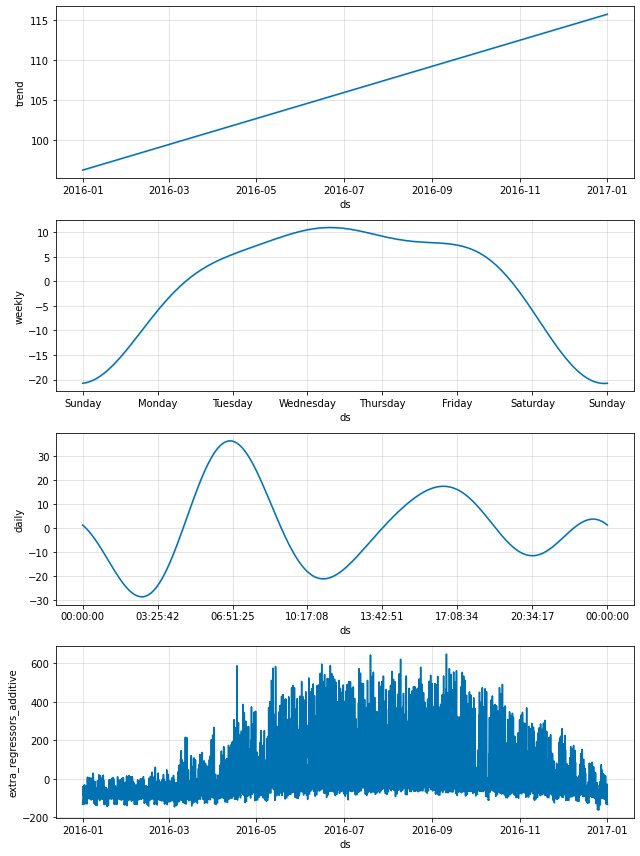

In [ ]:
fig = model.plot_components(model.predict(prophet_df), weekly_start = 1);

The above graph shows trend, seasonal patterns as well as the influence of the exogenous regressors.

**Trend**

It seems like the model has detected an increasing trend in the data. That is in contrast to the results of the dickey fuller test. 

**Weekly Seasonality**

The algorithm has detected the same seasonality as in our analysis in part 2. 

**Weekly Seasonality**

The algorithm has detected the same demand peeks as in our descriptive analysis. 

**External Regressors**

This graph is difficult to interpret since the impacts of all regressors are cumulated therefore the influence of each individual regressor is unclear. It seems like is chnges with according to the climate data. 

In [ ]:
%%time

# Starting a one-week-ahead prediction
prophet_cv = cross_validation(model, 
                              initial= '7500 hours', 
                              period= '100 hours', 
                              horizon= '24 hours'
                              )

INFO:fbprophet:Making 13 forecasts with cutoffs between 2016-11-10 23:00:00 and 2016-12-30 23:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 44.9 s, sys: 1.22 s, total: 46.2 s
Wall time: 45.7 s


In [ ]:
#create evaluation DataFrame
evaluation = pd.DataFrame({'Actuals': prophet_cv['y'],
                           'Prophet': prophet_cv['yhat']})

Test RMSE: 48.081
Test R2: 0.741


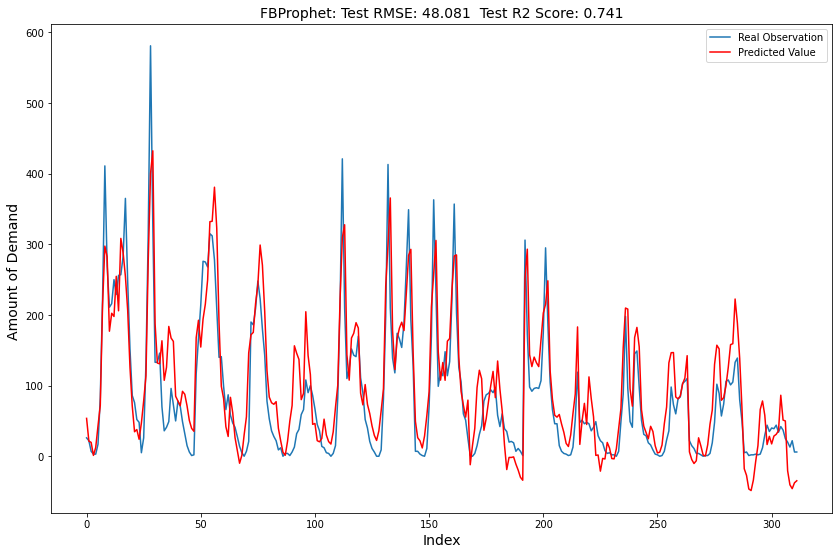

In [ ]:
#Calculate RMSE & R2

rmse = sqrt(mean_squared_error(evaluation.Actuals, evaluation.Prophet))
print(f'Test RMSE: %.3f' % rmse)
r2 = r2_score(evaluation.Actuals, evaluation.Prophet)
print('Test R2: %.3f' % r2)

# Plot Real vs Predicted Observations graphs
figure(figsize=(14, 9))
pyplot.plot(evaluation.Actuals, label='Real Observation')
pyplot.plot(evaluation.Prophet, color='red', label='Predicted Value')
pyplot.title(f'FBProphet: Test RMSE: {round(rmse, 3)}  Test R2 Score: {round(r2,3)}', fontsize =14)
pyplot.ylabel('Amount of Demand ', fontsize = 14)
pyplot.xlabel('Index', fontsize = 14)
pyplot.legend(loc='best')
pyplot.show()

## Remarks & Improvement Ideas

Unfortunately, I could not obtain results as good as our non-time series ensemble approaches. 
According to a literature research, this is probably due to the following reasons:
- in our data there are multiple seasonalities (Daily, Weekly, Monthly) with which Sarimax and FBProphet models seem to have problems
- I only have/use data from 2016, data from several years would be better
- usually the models are used more for daily or yearly forecasts instead of an hourly forecast
 
With more time, I would like to take a closer look at the topic. 
Attached, however, is at least an attempt with an FB Prophet approach: 

# References

[1] N. Arora, "How to check Stationarity of Data in Python", April 26, 2021. [Online]. Available: Analytics Vidhya, https://www.analyticsvidhya.com/blog/2021/04/how-to-check-stationarity-of-data-in-python/. [Accessed January 23, 2022].

[2] scikit-learn, "Time-related feature engineering", 2021. [Online]. Available: scikit-learn, https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html. [Accessed January 23, 2022].

[3] J. Brownlee, "How to Create an ARIMA Model for Time Series Forecasting in Python", January 09, 2017. [Online]. Available: Machine Learning Mastery, https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/. [Accessed January 23, 2022].

[4] P. Pawar, "Predicting Hourly Energy consumption of San Diego", unknown. [Online]. Available: towardsdatascience, https://towardsdatascience.com/part-2-time-series-analysis-predicting-hourly-energy-consumption-of-san-diego-ii-f09665796c9. [Accessed January 25, 2022].

[5] Meta, "Prophet Quick Start", unknown. [Online]. Available: towardsdatascience, https://facebook.github.io/prophet/docs/quick_start.html. [Accessed January 25, 2022].

